# Stationarity

The notebook from [this youtube video](https://www.youtube.com/watch?v=621MSxpYv60). He uses a [dataset](https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis/) that is often used for this exact purpose.

<Axes: >

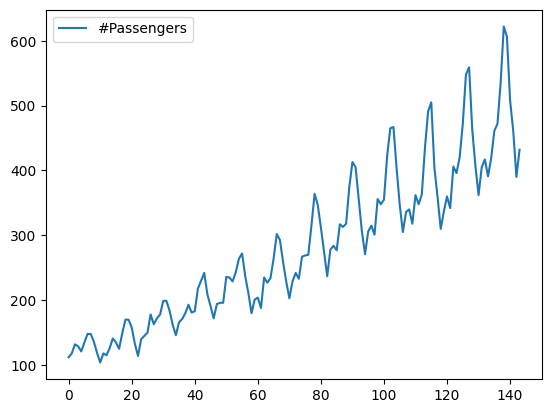

In [ ]:
import pandas as pd
import numpy as np

df_air = pd.read_csv("files/AirPassengers.csv")
df_air.plot()

What we see is that not only is the data going up, but the fluctuations are also increasing. This means it is not stationary because:

- There is a clear increasing trend
- There is a clear increasing variance

First we apply differencing.

<Axes: >

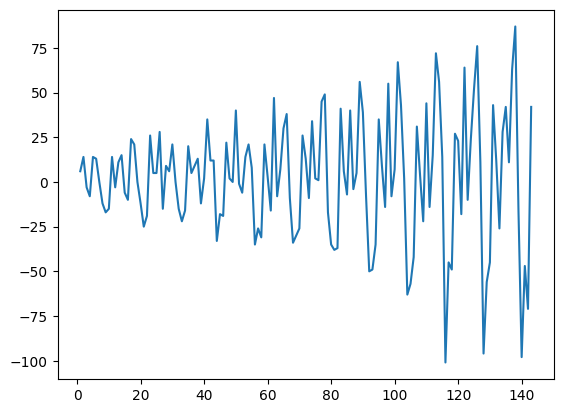

In [9]:
df_air["Passenger_Diff"] = df_air["#Passengers"].diff()
df_air["Passenger_Diff"].plot()

This completely removes the trend. That means the mean is now constant. The variance however is still unstable. This can be helped by using a log transform.

<Axes: >

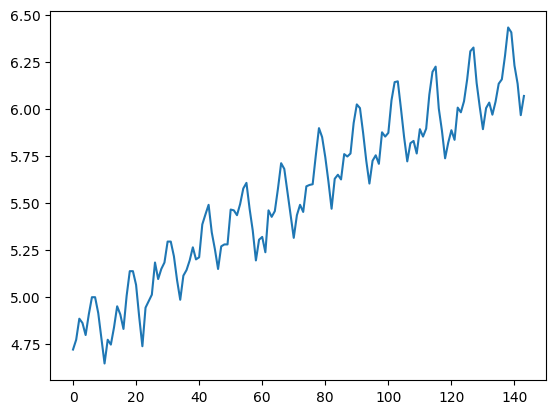

In [10]:
import numpy as np
df_air["Passenger_Log"] = np.log(df_air["#Passengers"])
df_air["Passenger_Log"].plot()

Now the trend is back, but the variance is constant. This means that the variance was actually exponential in our original dataset. What is we applied them both?

<Axes: >

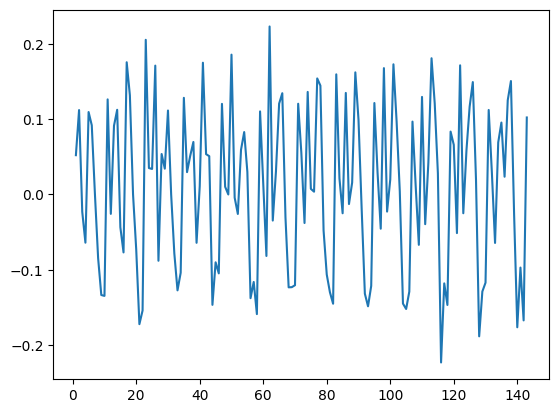

In [11]:
df_air["Passenger_Diff_Log"] = df_air["Passenger_Log"].diff()
df_air["Passenger_Diff_Log"].plot()

In the video a statistical test is now used to confirm that our data is stationary, but that would take us to far. The end of the video is though.

Why are we doing this? Aren't we deleting interesting information from the data?

No.

Because every data point has it's own mean and variance, it belongs to a different distribution. This was not the case when predicting non-time-series data, for example: when predicting ice cream sales as a function of temperature (warm: more ice creams sold) both the temperatures and the ice creams have a mean. These averages never change! When we look at ice cream sales as a function of time (ice cream sales going up from January until July) there is no common mean anymore, and therefore they don't have a common distribution.

This is the point where the youtube-video stops. But we could go further. Do some actual predictions on this dataset!

## Continue with manually transformed data

Egor Howell (the youtuber) did all the hard work of differencing and log transforming for us. Training a model, running the test set and untransforming the predicitions shouldn't be too much work.

Or should it?

The first step is changing the index of the dataframe.

In [14]:
df_air.head()

,Month,#Passengers,Passenger_Diff,Passenger_Log,Passenger_Diff_Log
0,1949-01,112,NaN,4.718499,NaN
1,1949-02,118,6.0,4.770685,0.052186
2,1949-03,132,14.0,4.882802,0.112117
3,1949-04,129,-3.0,4.859812,-0.022990
4,1949-05,121,-8.0,4.795791,-0.064022


We have a "month"-column, but it's not a date-time column and it's not the index of the dataframe either. We need to fix this before continuing.

In [16]:
# Create date range
date_range = pd.date_range(start="1949-01", periods=len(df_air), freq="MS")

# Assign as index
df_air.index = date_range
df_air.index.name = "Month"
df_air.head()

,Month,#Passengers,Passenger_Diff,Passenger_Log,Passenger_Diff_Log
Month,,,,,
1949-01-01,1949-01,112,NaN,4.718499,NaN
1949-02-01,1949-02,118,6.0,4.770685,0.052186
1949-03-01,1949-03,132,14.0,4.882802,0.112117
1949-04-01,1949-04,129,-3.0,4.859812,-0.022990
1949-05-01,1949-05,121,-8.0,4.795791,-0.064022


In [ ]:
# !pip install statsmodels

c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


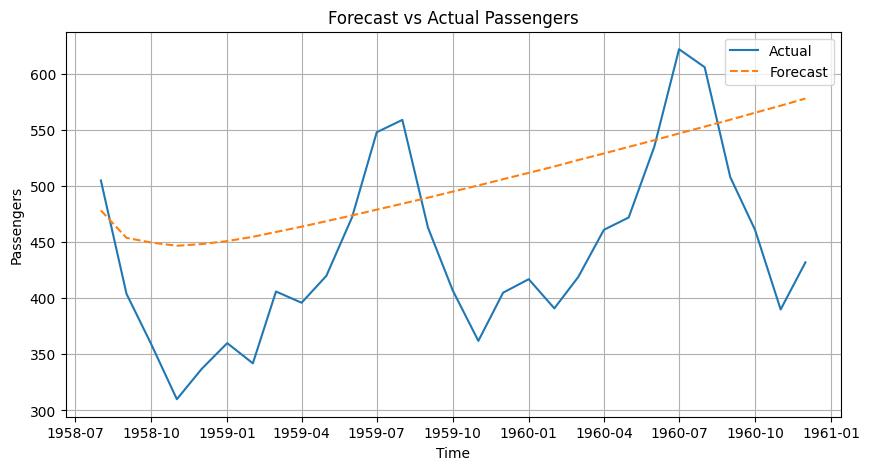

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1. LOAD DATA
# (Assuming df_air is already prepared and indexed by date)
# Apply transformations (as you did)
df_air["Passenger_Log"] = np.log(df_air["#Passengers"])
df_air["Passenger_Diff_Log"] = df_air["Passenger_Log"].diff()

# Drop the first NaN from differencing
df_diff = df_air["Passenger_Diff_Log"].dropna()

# 2. SPLIT TRAIN / TEST (e.g. 80/20 split)
split_point = int(len(df_diff) * 0.8)
train, test = df_diff.iloc[:split_point], df_diff.iloc[split_point:]

# 3. TRAIN ARIMA MODEL (no need for differencing again)
model = ARIMA(train, order=(2, 0, 2))  # no differencing because you already did it
model_fit = model.fit()

# 4. FORECAST
n_periods = len(test)
forecast_diff_log = model_fit.forecast(steps=n_periods)

# 5. UNDO DIFFERENCING
# We need the last known log value from training data
last_log_value = df_air["Passenger_Log"].iloc[split_point]

# Reconstruct log values from differenced forecast
forecast_log = forecast_diff_log.cumsum() + last_log_value

# 6. UNDO LOG TRANSFORMATION
forecast = np.exp(forecast_log)

# 7. COMPARE TO ACTUALS
actual = df_air["#Passengers"].iloc[split_point + 1: split_point + 1 + n_periods]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(actual.index, actual.values, label="Actual")
plt.plot(actual.index, forecast.values, label="Forecast", linestyle='--')
plt.title("Forecast vs Actual Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()


## Continue with auto-arima

Auto-arima is supposed to do all this for us. But there is a problem. Auto-arima is part of [pmdarima](https://github.com/alkaline-ml/pmdarima) and that repo has some problems:

* The last stable release was: 2.0.4 (mid 2023).
* The GitHub repo has:
    * Open issues and pull requests
    * Very few responses or merges
    * No sign of adapting to newer libraries (e.g., numpy 2.x, scikit-learn >=1.6)

* In short: it's useful but aging, and compatibility issues are becoming more common.
    * Still uses outdated scikit-learn APIs
    * Lags behind in adapting to numpy and pandas updates
    * Sparse documentation and long-standing bugs
    * Seasonal support (SARIMA) is limited to stepwise search and not very robust

The recommended alternative is using statsmodels, but that doesn't have an auto-arima. Anothet option is going for [statsforecast](https://github.com/Nixtla/statsforecast), which is actively maintained.

You could try it out, but be prepared to uninstall your numpy (which is at version 2.X) and install an older version. There will also be a ton of warnings because auto-arima is using deprecated features from sklearn.


In [ ]:
# !pip install statsforecast
# !pip install --upgrade jupyter ipywidgets

Let's train the auto-arima model. We're using the last 12 months as test-data. We're also inputting a season-length of 12, which is something we can calculate using auto-correlation.

In [53]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Load and prepare the AirPassengers dataset
df = pd.read_csv('files/AirPassengers.csv')
df['ds'] = pd.to_datetime(df['Month'])
df['y'] = df['#Passengers']
df['unique_id'] = 'air'

# Keep only required columns
df = df[['unique_id', 'ds', 'y']]

# Split: last 12 months as test
h = 12
df_train = df[:-h].copy()
df_test = df[-h:].copy()

# Fit AutoARIMA on training set
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='ME',
    n_jobs=1
)

sf.fit(df_train)


StatsForecast(models=[AutoARIMA])

In [58]:
df_test.head()

,unique_id,ds,y
132,air,1960-01-01,417
133,air,1960-02-01,391
134,air,1960-03-01,419
135,air,1960-04-01,461
136,air,1960-05-01,472


Model is done in 3 seconds (on my machine). What RMSE are we getting?

In [59]:
from sklearn.metrics import mean_squared_error

# Forecast the next 12 months
df_forecast = sf.predict(h=h)
df_forecast["y"] = df_forecast["AutoARIMA"]

rmse = np.sqrt(mean_squared_error(df_test["y"], df_forecast["y"]))
print(f"RMSE on test set: {rmse:.4f} passengers")

RMSE on test set: 23.9195 passengers


Let's look at the results in a graph.

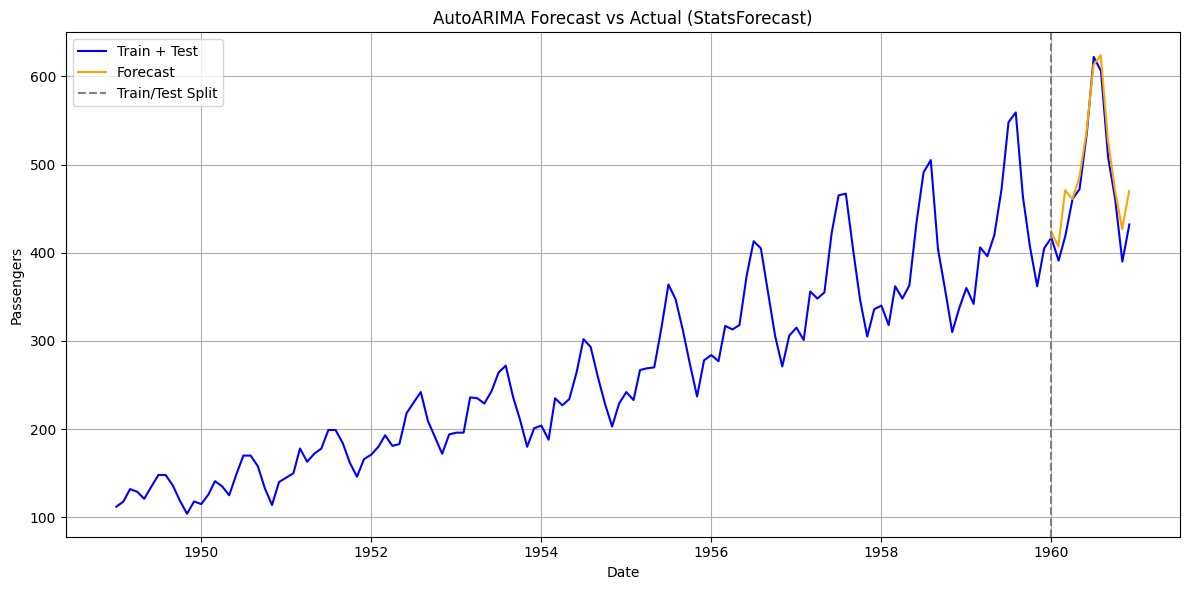

In [60]:
# Combine for plotting
df_plot = pd.concat([df_train, df_test], ignore_index=True)
df_forecast['type'] = 'Forecast'
df_test['type'] = 'Actual'

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(df_plot['ds'], df_plot['y'], label='Train + Test', color='blue')
plt.plot(df_forecast['ds'], df_forecast['y'], label='Forecast', color='orange')
plt.axvline(df_test['ds'].iloc[0], linestyle='--', color='gray', label='Train/Test Split')
plt.title('AutoARIMA Forecast vs Actual (StatsForecast)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Continue with manual grid search

In [47]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("files/AirPassengers.csv")
df['ds'] = pd.to_datetime(df['Month'])
df.set_index('ds', inplace=True)
y = df['#Passengers']

# Train/test split: last 12 months as test
train = y[:-12].copy()
test = y[-12:].copy()

# Define parameter ranges
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Grid search
best_aic = np.inf
best_order = None
best_seasonal = None
best_model = None

print("Starting grid search...")
for order in itertools.product(p, d, q):
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = results
        except:
            continue

print(f"Best model: ARIMA{best_order}x{best_seasonal} - AIC: {best_aic:.2f}")

Starting grid search...


c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Scripts\Cello_AI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Best model: ARIMA(0, 2, 2)x(0, 2, 2, 12) - AIC: 603.94


This took a lot longer to train. That is because in stead of using statistical methods to determine the best value we're now simply trying them all. And "all" means 27 models. That still doesn't explain the 7 minutes this code-block took, though.

But this line does:
```Python
for order in itertools.product(p, d, q):       # 27 combinations
    for seasonal_order in seasonal_pdq:        # nested: 27 more
```

But why? We're tuning two different sets of parameters:
* Non-seasonal order (p, d, q): Captures short-term autoregressive/moving average behavior
* Seasonal order (P, D, Q, s): Captures repeating seasonal patterns (e.g., yearly seasonality for monthly data: s = 12)

Each full SARIMA model needs both:

```Python
SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
```
Se we're not training 27 models but 729. Auto_arima is faster because:
* Early Stopping: If certain models are clearly worse, it prunes them quickly.
* Caching + Optimization: auto_arima caches results and avoids refitting duplicates (e.g., if p=1, q=2 is the same as q=2, p=1 in effect).

But what is the result we get?

In [52]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE on test set: {rmse:.4f} passengers")

RMSE on test set: 20.3829 passengers


And the graph?

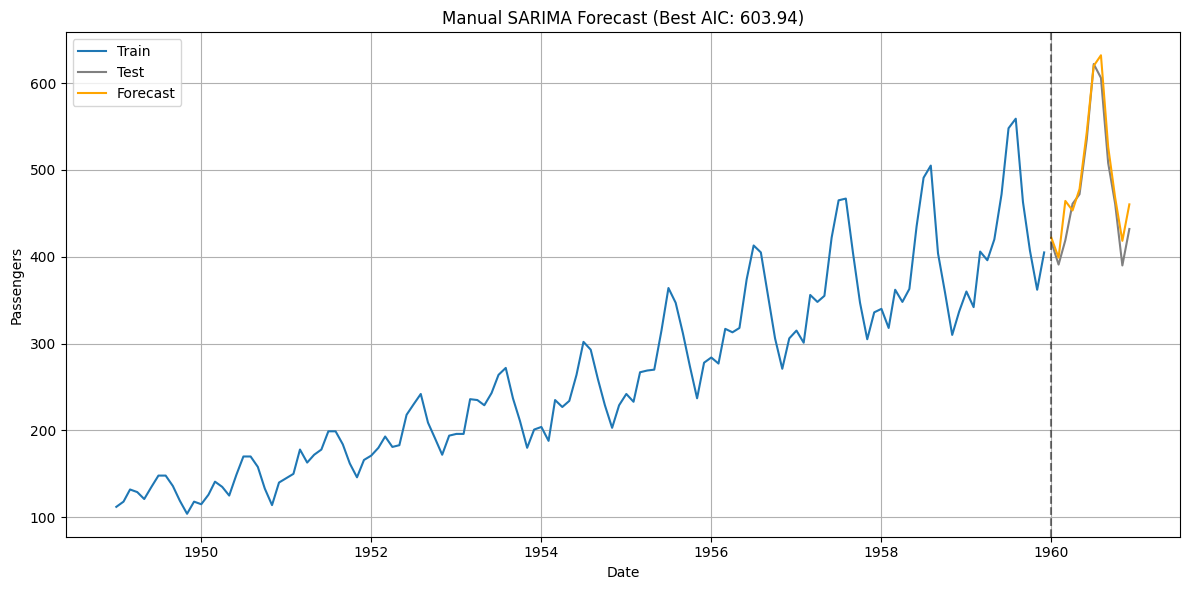

In [50]:
# Forecast the test period
pred = best_model.get_forecast(steps=12)
forecast = pred.predicted_mean

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(forecast.index, forecast, label='Forecast', color='orange')
plt.axvline(test.index[0], linestyle='--', color='black', alpha=0.5)
plt.title(f'Manual SARIMA Forecast (Best AIC: {best_aic:.2f})')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary


| Feature          | `auto_arima()`          | Manual Grid Search    |
| ---------------- | ----------------------- | --------------------- |
| Easy to use      | Yes                     | Requires coding       |
| Fast (stepwise)  | Yes                     |Slow if full grid      |
| Seasonal support | Yes (`seasonal=True`)   |Yes (SARIMA)           |
| Custom scoring   | Limited                 |Fully customizable     |
| Best for         | Most use cases          | Research, fine-tuning |
